# **Brain Tumor Detection in MRI Scans**

This notebook demonstrates a comprehensive approach to classifying brain MRI scans as either containing a tumor or not. We use a combination of custom artificial neural networks (ANN) and pre-trained models (VGG-Net and ResNet) to achieve this. Below, we will walk through the necessary steps, from loading the dataset to evaluating the model's performance.

---

## **1. Importing Libraries**

In this section, we import the essential libraries required for handling datasets, creating models, and performing various image processing tasks.


In [1]:
import os
import glob
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


---

## **2. Loading and Visualizing the Dataset**

Here, we define the paths to the dataset, load the images, and visualize some samples. The dataset is assumed to be structured with separate folders for "tumor" (`yes`) and "non-tumor" (`no`) images.

### **2.1. Define Paths and Load Images**


In [2]:
# Define the paths to the "yes" and "no" folders
yes = './brain_tumor_dataset/yes'
no = './brain_tumor_dataset/no'

# Load all images with specified extensions into corresponding variables
tumor = glob.glob(os.path.join(yes, '*.jpg')) + glob.glob(os.path.join(yes, '*.png'))
non_tumor = glob.glob(os.path.join(no, '*.jpg')) + glob.glob(os.path.join(no, '*.jpeg')) + glob.glob(os.path.join(no, '*.png'))

# Display the number of images loaded for each class
print(f"Number of 'yes' images: {len(tumor)}")
print(f"Number of 'no' images: {len(non_tumor)}")


Number of 'yes' images: 155
Number of 'no' images: 98


### **2.2. Visualize Sample Images**

We define a function to display a few sample images from each class (`yes` and `no`) to ensure that the images are loaded correctly.


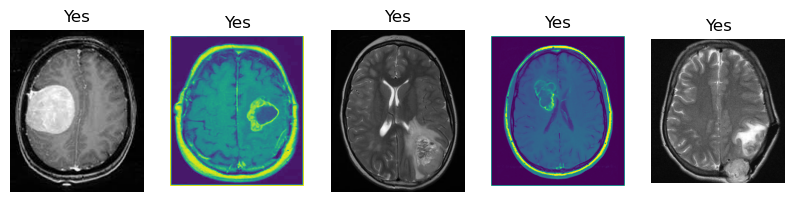

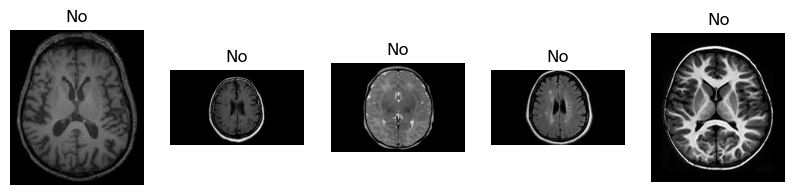

In [3]:
# Function to display a list of images
def display_images(image_paths, title):
    plt.figure(figsize=(10, 5))
    for i, image_path in enumerate(image_paths[:5]):  # Show first 5 images
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Display sample images from the 'yes' and 'no' folders
display_images(tumor, 'Yes')
display_images(non_tumor, 'No')


---

## **3. Custom Dataset Class and Transformations**

We create a custom dataset class to handle loading and transforming the images. Additionally, we define the necessary transformations, including resizing and normalization.

### **3.1. Define Custom Dataset Class**


In [4]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.yes_dir = os.path.join(root_dir, 'yes')
        self.no_dir = os.path.join(root_dir, 'no')
        self.yes_images = [(os.path.join(self.yes_dir, img), 1) for img in os.listdir(self.yes_dir)]
        self.no_images = [(os.path.join(self.no_dir, img), 0) for img in os.listdir(self.no_dir)]
        self.all_images = self.yes_images + self.no_images
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### **3.2. Define Image Transformations**

We apply several transformations to the images, such as resizing, converting them to tensors, and normalizing them.


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet dataset statistics
])


---

## **4. Dataset Preparation**

We initialize the dataset, split it into training and testing sets, and create data loaders for both.


In [6]:
# Set the random seed for reproducibility
random_seed = 0
torch.manual_seed(random_seed)

# Initialize the dataset with transformations
dataset = BrainMRIDataset(root_dir='./brain_tumor_dataset', transform=transform)

# Split the dataset into training (80%) and testing (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=35, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=35, shuffle=False)


### **4.1. Display Sample Data**

We print out a few samples from the training and testing data to confirm the dataset's integrity.


In [7]:
# Print a few samples from the train data
print("Train Data:")
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i+1} - Label: {label}")

# Print a few samples from the test data
print("\nTest Data:")
for i in range(5):
    image, label = test_dataset[i]
    print(f"Image {i+1} - Label: {label}")


Train Data:
Image 1 - Label: 1
Image 2 - Label: 0
Image 3 - Label: 1
Image 4 - Label: 1
Image 5 - Label: 0

Test Data:
Image 1 - Label: 0
Image 2 - Label: 1
Image 3 - Label: 1
Image 4 - Label: 1
Image 5 - Label: 0


---

## **5. Model Training**

In this section, we define a custom artificial neural network (ANN), initialize the model, loss function, and optimizer, and train the model on the training data.

### **5.1. Define Custom ANN Model**


In [8]:
# Define the custom ANN
class CustomANN(nn.Module):
    def __init__(self):
        super(CustomANN, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 512)  # Input layer (flattened image size) to 512 features
        self.fc2 = nn.Linear(512, 128)  # Hidden layer: 512 features to 128 features
        self.fc3 = nn.Linear(128, 2)  # Output layer: 128 features to 2 classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # Flatten the image
        x = F.relu(self.fc1(x))  # First layer with ReLU activation
        x = F.relu(self.fc2(x))  # Second layer with ReLU activation
        x = self.fc3(x)  # Output layer
        return x

# Initialize the model, loss function, and optimizer
model_ann = CustomANN()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)  # Adam optimizer


### **5.2. Training Function**

We define a function to train the ANN model over a specified number of epochs.


In [9]:
# Training function for the custom ANN model
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        correct_predictions = 0
        total_samples = 0
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Train the model
train_model(model_ann, train_loader, criterion, optimizer)


Epoch 1/50, Loss: 18.0180, Accuracy: 57.43%
Epoch 2/50, Loss: 5.2652, Accuracy: 66.34%
Epoch 3/50, Loss: 1.8499, Accuracy: 79.70%
Epoch 4/50, Loss: 1.5771, Accuracy: 79.70%
Epoch 5/50, Loss: 0.4963, Accuracy: 89.11%
Epoch 6/50, Loss: 0.3003, Accuracy: 89.11%
Epoch 7/50, Loss: 0.1716, Accuracy: 94.55%
Epoch 8/50, Loss: 0.4932, Accuracy: 86.63%
Epoch 9/50, Loss: 0.7170, Accuracy: 86.14%
Epoch 10/50, Loss: 0.2061, Accuracy: 93.07%
Epoch 11/50, Loss: 0.1250, Accuracy: 96.53%
Epoch 12/50, Loss: 0.0319, Accuracy: 98.02%
Epoch 13/50, Loss: 0.0192, Accuracy: 99.50%
Epoch 14/50, Loss: 0.0154, Accuracy: 99.01%
Epoch 15/50, Loss: 0.0033, Accuracy: 100.00%
Epoch 16/50, Loss: 0.0081, Accuracy: 100.00%
Epoch 17/50, Loss: 0.0011, Accuracy: 100.00%
Epoch 18/50, Loss: 0.0012, Accuracy: 100.00%
Epoch 19/50, Loss: 0.0008, Accuracy: 100.00%
Epoch 20/50, Loss: 0.0007, Accuracy: 100.00%
Epoch 21/50, Loss: 0.0006, Accuracy: 100.00%
Epoch 22/50, Loss: 0.0005, Accuracy: 100.00%
Epoch 23/50, Loss: 0.0005, Accur

---

## **6. Using Pre-trained Models**

We also experiment with using pre-trained VGG-Net and ResNet models, which are modified to suit our binary classification task.

### **6.1. Load and Modify Pre-trained Models**


In [10]:
# Load and modify VGG-Net
model_vgg = models.vgg16(weights='DEFAULT')
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier[6] = nn.Linear(4096, 2)

# Load and modify ResNet
model_resnet = models.resnet50(weights='DEFAULT')
for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Anas/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


### **6.2. Train Pre-trained Models**

We train both the modified VGG-Net and ResNet models on our dataset.


In [11]:
# Function to train the pre-trained models
def train_pretrained_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        correct_predictions = 0
        total_samples = 0
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Initialize loss and optimizer for pre-trained models
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# Train the VGG and ResNet models
train_pretrained_model(model_vgg, train_loader, criterion, optimizer_vgg)
train_pretrained_model(model_resnet, train_loader, criterion, optimizer_resnet)


Epoch 1/50, Loss: 0.7487, Accuracy: 61.39%
Epoch 2/50, Loss: 0.5329, Accuracy: 74.75%
Epoch 3/50, Loss: 0.4447, Accuracy: 82.18%
Epoch 4/50, Loss: 0.4433, Accuracy: 80.20%
Epoch 5/50, Loss: 0.3585, Accuracy: 86.14%
Epoch 6/50, Loss: 0.3286, Accuracy: 86.14%
Epoch 7/50, Loss: 0.3311, Accuracy: 86.63%
Epoch 8/50, Loss: 0.3378, Accuracy: 86.63%
Epoch 9/50, Loss: 0.3710, Accuracy: 85.64%
Epoch 10/50, Loss: 0.3297, Accuracy: 88.12%
Epoch 11/50, Loss: 0.2892, Accuracy: 86.63%
Epoch 12/50, Loss: 0.2957, Accuracy: 88.12%
Epoch 13/50, Loss: 0.2635, Accuracy: 88.61%
Epoch 14/50, Loss: 0.2669, Accuracy: 88.61%
Epoch 15/50, Loss: 0.2510, Accuracy: 90.10%
Epoch 16/50, Loss: 0.2579, Accuracy: 90.59%
Epoch 17/50, Loss: 0.2222, Accuracy: 90.59%
Epoch 18/50, Loss: 0.2016, Accuracy: 92.57%
Epoch 19/50, Loss: 0.2119, Accuracy: 92.08%
Epoch 20/50, Loss: 0.1995, Accuracy: 91.58%
Epoch 21/50, Loss: 0.2043, Accuracy: 92.08%
Epoch 22/50, Loss: 0.1974, Accuracy: 92.08%
Epoch 23/50, Loss: 0.1989, Accuracy: 90.1

---

## **7. Model Evaluation**

We evaluate the performance of our trained models on the test set using accuracy, precision, recall, and confusion matrix.

### **7.1. Define Evaluation Function**


In [21]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    if len(y_true) == 0:  # Ensure there are ground truth labels
        print("No data in test loader.")
        return None

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    return accuracy

# Evaluate the custom ANN model
print("Evaluating Custom ANN Model:")
acc_ann = evaluate_model(model_ann, test_loader)
print(f"ANN Model Accuracy: {acc_ann}")

# Evaluate the VGG model
print("\nEvaluating VGG Model:")
acc_vgg = evaluate_model(model_vgg, test_loader)
print(f"VGG Model Accuracy: {acc_vgg}")

# Evaluate the ResNet model
print("\nEvaluating ResNet Model:")
acc_resnet = evaluate_model(model_resnet, test_loader)
print(f"ResNet Model Accuracy: {acc_resnet}")


Evaluating Custom ANN Model:
Accuracy: 80.39%
Precision: 80.00%
Recall: 90.32%
Confusion Matrix:
[[13  7]
 [ 3 28]]
ANN Model Accuracy: 0.803921568627451

Evaluating VGG Model:
Accuracy: 84.31%
Precision: 87.10%
Recall: 87.10%
Confusion Matrix:
[[16  4]
 [ 4 27]]
VGG Model Accuracy: 0.8431372549019608

Evaluating ResNet Model:
Accuracy: 92.16%
Precision: 90.91%
Recall: 96.77%
Confusion Matrix:
[[17  3]
 [ 1 30]]
ResNet Model Accuracy: 0.9215686274509803


### **7.2 Determine the best model based on accuracy**

In [22]:
if acc_ann is None or acc_vgg is None or acc_resnet is None:
    print("Error: One of the models did not return a valid accuracy.")
else:
    # Determine the best model based on accuracy
    best_accuracy = max(acc_ann, acc_vgg, acc_resnet)
    if best_accuracy == acc_ann:
        best_model = model_ann
        best_model_name = 'ANN'
    elif best_accuracy == acc_vgg:
        best_model = model_vgg
        best_model_name = 'VGG-Net'
    else:
        best_model = model_resnet
        best_model_name = 'ResNet'

    save_path = './'
    torch.save(best_model, save_path + f'{best_model_name}_best_model.pth')
    print(f"{best_model_name} model saved as {save_path}{best_model_name}_best_model.pth")

ResNet model saved as ./ResNet_best_model.pth


---

## **8. Conclusion**

This notebook demonstrates the process of building and evaluating a model for brain tumor detection using MRI scans. We explored both custom neural networks and pre-trained models, highlighting the advantages of each approach.
